In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Libraries imported successfully!")


TensorFlow version: 2.19.0
Libraries imported successfully!


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Original data shapes:
X_train: (60000, 28, 28)
y_train: (60000,)
X_test: (10000, 28, 28)
y_test: (10000,)


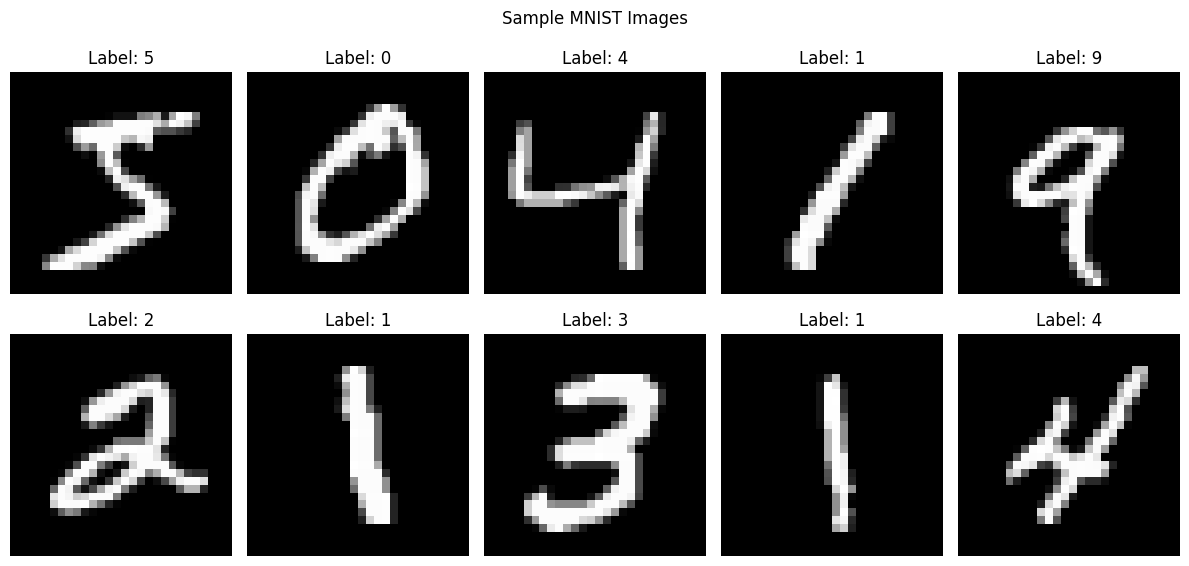


After preprocessing:
X_train_flat: (60000, 784)
X_test_flat: (10000, 784)
y_train_cat: (60000, 10)
y_test_cat: (10000, 10)
Feature range: [0.00, 1.00]


In [ ]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Original data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Visualize some sample images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}')
    plt.axis('off')
plt.suptitle('Sample MNIST Images')
plt.tight_layout()
plt.show()

# Preprocess the data
# Flatten the 28x28 images to 784-dimensional vectors
X_train_flat = X_train.reshape(X_train.shape[0], 28*28).astype('float32')
X_test_flat = X_test.reshape(X_test.shape[0], 28*28).astype('float32')

# Normalize pixel values to [0, 1]
X_train_flat = X_train_flat / 255.0
X_test_flat = X_test_flat / 255.0

# One-hot encode the labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("\nAfter preprocessing:")
print(f"X_train_flat: {X_train_flat.shape}")
print(f"X_test_flat: {X_test_flat.shape}")
print(f"y_train_cat: {y_train_cat.shape}")
print(f"y_test_cat: {y_test_cat.shape}")
print(f"Feature range: [{X_train_flat.min():.2f}, {X_train_flat.max():.2f}]")


In [ ]:
def create_mlp_model(dropout_rate=0.0, hidden_units=[512, 256, 128]):
    """
    Create a Multi-Layer Perceptron model with optional dropout

    Args:
        dropout_rate (float): Dropout rate (0.0 for no dropout)
        hidden_units (list): List of units in each hidden layer

    Returns:
        Compiled Keras model
    """
    model = Sequential([
        Dense(hidden_units[0], activation='relu', input_shape=(784,), name='hidden_1'),
        Dropout(dropout_rate, name=f'dropout_1_{dropout_rate}'),

        Dense(hidden_units[1], activation='relu', name='hidden_2'),
        Dropout(dropout_rate, name=f'dropout_2_{dropout_rate}'),

        Dense(hidden_units[2], activation='relu', name='hidden_3'),
        Dropout(dropout_rate, name=f'dropout_3_{dropout_rate}'),

        Dense(10, activation='softmax', name='output')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Test model creation
test_model = create_mlp_model(dropout_rate=0.2)
test_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1_0.2 (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2_0.2 (Dropout)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3_0.2 (Dropout)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 567,434 (2.16 MB)

 Trainable params: 567,434 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_model_with_tracking(dropout_rate, epochs=20, batch_size=128, runs=3):
    """
    Train multiple models with the same dropout rate to measure variance

    Args:
        dropout_rate (float): Dropout rate to use
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        runs (int): Number of training runs for variance analysis

    Returns:
        Dictionary containing training results
    """
    results = {
        'dropout_rate': dropout_rate,
        'train_accuracies': [],
        'val_accuracies': [],
        'histories': [],
        'final_train_acc': [],
        'final_val_acc': []
    }

    for run in range(runs):
        print(f"\n--- Training Run {run+1}/{runs} for Dropout Rate {dropout_rate} ---")

        # Create and compile model
        model = create_mlp_model(dropout_rate=dropout_rate)

        # Train the model
        history = model.fit(
            X_train_flat, y_train_cat,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test_flat, y_test_cat),
            verbose=1
        )

        # Store results
        results['histories'].append(history.history)
        results['final_train_acc'].append(history.history['accuracy'][-1])
        results['final_val_acc'].append(history.history['val_accuracy'][-1])

        # Evaluate final performance
        train_loss, train_acc = model.evaluate(X_train_flat, y_train_cat, verbose=0)
        val_loss, val_acc = model.evaluate(X_test_flat, y_test_cat, verbose=0)

        print(f"Run {run+1} - Final Train Accuracy: {train_acc:.4f}")
        print(f"Run {run+1} - Final Validation Accuracy: {val_acc:.4f}")

        results['train_accuracies'].append(train_acc)
        results['val_accuracies'].append(val_acc)

    return results


In [ ]:
# Define experimental setup
dropout_rates = [0.0, 0.2, 0.5]  # Baseline, low dropout, high dropout
epochs = 15  # Reduced for faster execution in Colab
runs = 3     # Multiple runs to measure variance

# Store all results
all_results = {}

# Run experiments for each dropout rate
for dropout_rate in dropout_rates:
    print(f"\n{'='*60}")
    print(f"EXPERIMENTING WITH DROPOUT RATE: {dropout_rate}")
    print(f"{'='*60}")

    results = train_model_with_tracking(
        dropout_rate=dropout_rate,
        epochs=epochs,
        runs=runs
    )

    all_results[dropout_rate] = results

    # Print summary statistics
    mean_train_acc = np.mean(results['train_accuracies'])
    std_train_acc = np.std(results['train_accuracies'])
    mean_val_acc = np.mean(results['val_accuracies'])
    std_val_acc = np.std(results['val_accuracies'])

    print(f"\nSUMMARY for Dropout Rate {dropout_rate}:")
    print(f"Training Accuracy: {mean_train_acc:.4f} ± {std_train_acc:.4f}")
    print(f"Validation Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")
    print(f"Overfitting Gap: {mean_train_acc - mean_val_acc:.4f}")



EXPERIMENTING WITH DROPOUT RATE: 0.0

--- Training Run 1/3 for Dropout Rate 0.0 ---
Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8756 - loss: 0.4186 - val_accuracy: 0.9641 - val_loss: 0.1138
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9715 - loss: 0.0941 - val_accuracy: 0.9725 - val_loss: 0.0876
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9827 - loss: 0.0564 - val_accuracy: 0.9778 - val_loss: 0.0750
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9873 - loss: 0.0389 - val_accuracy: 0.9790 - val_loss: 0.0746
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9895 - loss: 0.0306 - val_accuracy: 0.9782 - val_loss: 0.0799
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9908 - loss: 0.0281 - val_accuracy: 0.9789 - val_loss: 0.0774
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.9934 - loss: 0.0203 - val_accuracy: 0.9790 - val_loss: 0.0840
Epoch 8/15
4

In [ ]:
# Create results summary table
results_summary = []

for dropout_rate in dropout_rates:
    results = all_results[dropout_rate]

    mean_train = np.mean(results['train_accuracies'])
    std_train = np.std(results['train_accuracies'])
    mean_val = np.mean(results['val_accuracies'])
    std_val = np.std(results['val_accuracies'])
    overfitting_gap = mean_train - mean_val

    results_summary.append({
        'Dropout Rate': dropout_rate,
        'Train Acc (Mean)': f"{mean_train:.4f}",
        'Train Acc (Std)': f"{std_train:.4f}",
        'Val Acc (Mean)': f"{mean_val:.4f}",
        'Val Acc (Std)': f"{std_val:.4f}",
        'Overfitting Gap': f"{overfitting_gap:.4f}"
    })

# Convert to DataFrame and display
summary_df = pd.DataFrame(results_summary)
print("EXPERIMENTAL RESULTS SUMMARY:")
print("="*70)
print(summary_df.to_string(index=False))


EXPERIMENTAL RESULTS SUMMARY:
 Dropout Rate Train Acc (Mean) Train Acc (Std) Val Acc (Mean) Val Acc (Std) Overfitting Gap
          0.0           0.9969          0.0015         0.9803        0.0020          0.0166
          0.2           0.9978          0.0001         0.9834        0.0009          0.0144
          0.5           0.9938          0.0003         0.9822        0.0003          0.0116


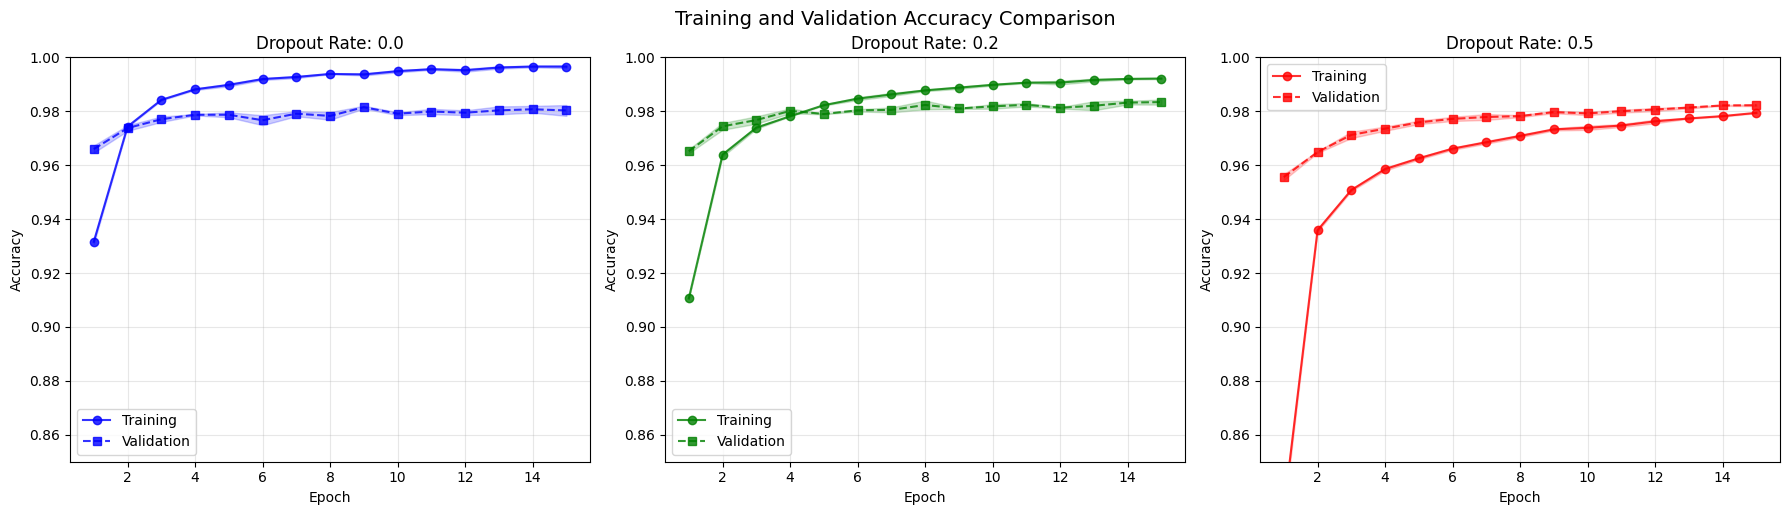

In [ ]:
# Plot training and validation accuracy curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['blue', 'green', 'red']

for idx, dropout_rate in enumerate(dropout_rates):
    ax = axes[idx]
    results = all_results[dropout_rate]

    # Average the histories across runs
    epochs_range = range(1, epochs + 1)

    # Calculate mean and std for training and validation accuracy
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        epoch_train_accs = [hist['accuracy'][epoch] for hist in results['histories']]
        epoch_val_accs = [hist['val_accuracy'][epoch] for hist in results['histories']]
        train_accs.append(epoch_train_accs)
        val_accs.append(epoch_val_accs)

    train_means = [np.mean(epoch_accs) for epoch_accs in train_accs]
    train_stds = [np.std(epoch_accs) for epoch_accs in train_accs]
    val_means = [np.mean(epoch_accs) for epoch_accs in val_accs]
    val_stds = [np.std(epoch_accs) for epoch_accs in val_accs]

    # Plot with error bars
    ax.plot(epochs_range, train_means, 'o-', color=colors[idx], label='Training', alpha=0.8)
    ax.fill_between(epochs_range,
                    [m-s for m,s in zip(train_means, train_stds)],
                    [m+s for m,s in zip(train_means, train_stds)],
                    alpha=0.2, color=colors[idx])

    ax.plot(epochs_range, val_means, 's--', color=colors[idx], label='Validation', alpha=0.8)
    ax.fill_between(epochs_range,
                    [m-s for m,s in zip(val_means, val_stds)],
                    [m+s for m,s in zip(val_means, val_stds)],
                    alpha=0.2, color=colors[idx])

    ax.set_title(f'Dropout Rate: {dropout_rate}', fontsize=12)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_ylim([0.85, 1.0])

plt.tight_layout()
plt.suptitle('Training and Validation Accuracy Comparison', fontsize=14, y=1.02)
plt.show()


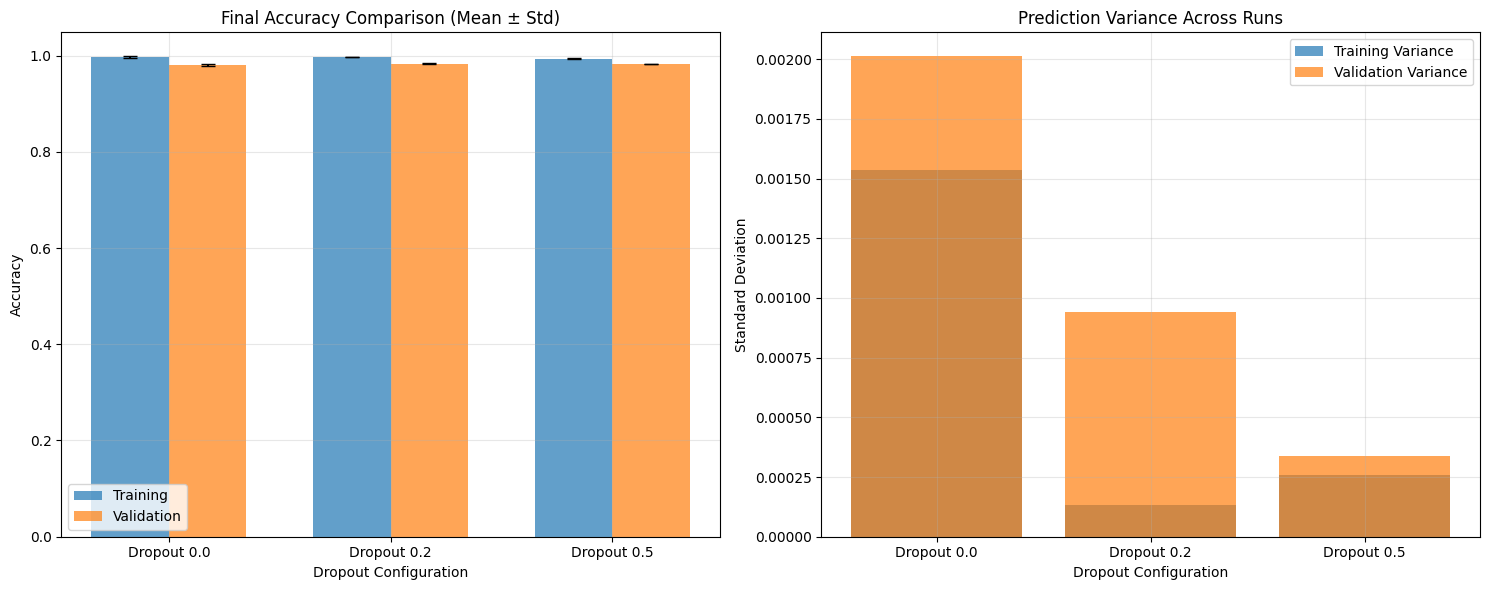

VARIANCE ANALYSIS:
Dropout 0.0: Train Variance = 0.000002, Val Variance = 0.000004
Dropout 0.2: Train Variance = 0.000000, Val Variance = 0.000001
Dropout 0.5: Train Variance = 0.000000, Val Variance = 0.000000


In [ ]:
# Create variance analysis plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Final accuracies comparison
dropout_labels = [f'Dropout {rate}' for rate in dropout_rates]
train_means = [np.mean(all_results[rate]['train_accuracies']) for rate in dropout_rates]
train_stds = [np.std(all_results[rate]['train_accuracies']) for rate in dropout_rates]
val_means = [np.mean(all_results[rate]['val_accuracies']) for rate in dropout_rates]
val_stds = [np.std(all_results[rate]['val_accuracies']) for rate in dropout_rates]

x = np.arange(len(dropout_labels))
width = 0.35

bars1 = ax1.bar(x - width/2, train_means, width, yerr=train_stds,
                label='Training', alpha=0.7, capsize=5)
bars2 = ax1.bar(x + width/2, val_means, width, yerr=val_stds,
                label='Validation', alpha=0.7, capsize=5)

ax1.set_xlabel('Dropout Configuration')
ax1.set_ylabel('Accuracy')
ax1.set_title('Final Accuracy Comparison (Mean ± Std)')
ax1.set_xticks(x)
ax1.set_xticklabels(dropout_labels)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Variance (standard deviation) comparison
ax2.bar(dropout_labels, train_stds, alpha=0.7, label='Training Variance')
ax2.bar(dropout_labels, val_stds, alpha=0.7, label='Validation Variance')
ax2.set_xlabel('Dropout Configuration')
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Prediction Variance Across Runs')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print variance analysis
print("VARIANCE ANALYSIS:")
print("="*50)
for rate in dropout_rates:
    train_var = np.var(all_results[rate]['train_accuracies'])
    val_var = np.var(all_results[rate]['val_accuracies'])
    print(f"Dropout {rate}: Train Variance = {train_var:.6f}, Val Variance = {val_var:.6f}")



Training final model with dropout rate 0.0
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Classification Report for Dropout 0.0:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000


Training final model with dropout rate 0.2
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report for Drop

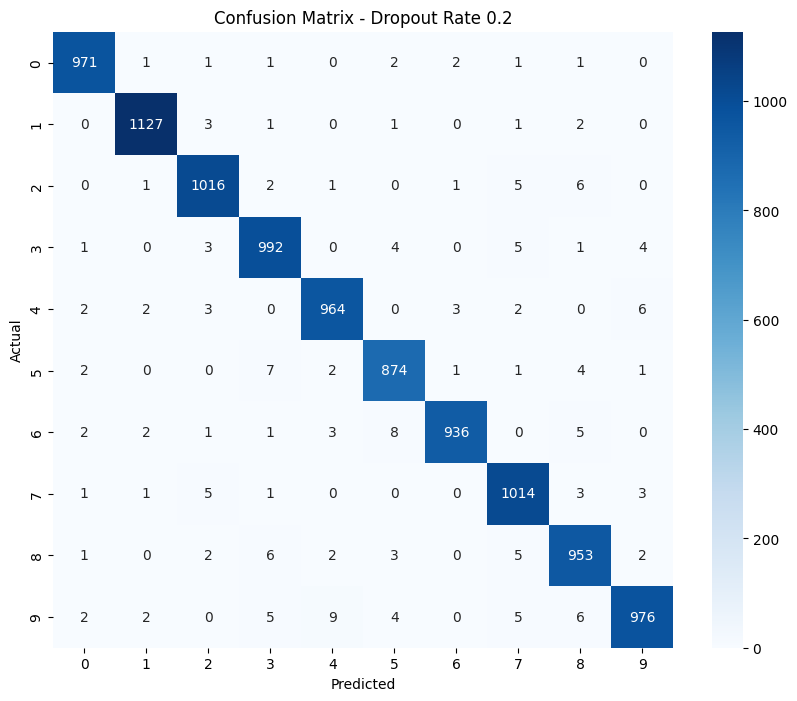

In [ ]:
# Train final models for detailed analysis
final_models = {}

for dropout_rate in dropout_rates:
    print(f"\nTraining final model with dropout rate {dropout_rate}")
    model = create_mlp_model(dropout_rate=dropout_rate)

    history = model.fit(
        X_train_flat, y_train_cat,
        batch_size=128,
        epochs=epochs,
        validation_data=(X_test_flat, y_test_cat),
        verbose=0
    )

    final_models[dropout_rate] = model

    # Get predictions
    y_pred = model.predict(X_test_flat)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Classification report
    print(f"\nClassification Report for Dropout {dropout_rate}:")
    print(classification_report(y_test, y_pred_classes))

# Create confusion matrix for the best performing model
best_dropout = 0.2  # You can change this based on your results
best_model = final_models[best_dropout]
y_pred_best = best_model.predict(X_test_flat)
y_pred_classes_best = np.argmax(y_pred_best, axis=1)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_classes_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - Dropout Rate {best_dropout}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
# Final analysis and key findings
print("KEY FINDINGS AND ANALYSIS:")
print("="*60)

print("\n1. OVERFITTING ANALYSIS:")
for rate in dropout_rates:
    results = all_results[rate]
    mean_train = np.mean(results['train_accuracies'])
    mean_val = np.mean(results['val_accuracies'])
    gap = mean_train - mean_val

    if rate == 0.0:
        print(f"   Baseline (no dropout): Overfitting gap = {gap:.4f}")
    else:
        print(f"   Dropout {rate}: Overfitting gap = {gap:.4f}")

print("\n2. REGULARIZATION EFFECT:")
baseline_gap = np.mean(all_results[0.0]['train_accuracies']) - np.mean(all_results[0.0]['val_accuracies'])
for rate in [0.2, 0.5]:
    current_gap = np.mean(all_results[rate]['train_accuracies']) - np.mean(all_results[rate]['val_accuracies'])
    improvement = baseline_gap - current_gap
    print(f"   Dropout {rate} reduced overfitting by {improvement:.4f} compared to baseline")

print("\n3. VARIANCE REDUCTION:")
baseline_val_std = np.std(all_results[0.0]['val_accuracies'])
for rate in [0.2, 0.5]:
    current_val_std = np.std(all_results[rate]['val_accuracies'])
    reduction = (baseline_val_std - current_val_std) / baseline_val_std * 100
    print(f"   Dropout {rate} changed validation variance by {reduction:.2f}% compared to baseline")

print("\n4. RECOMMENDATIONS:")
best_val_acc = max([np.mean(all_results[rate]['val_accuracies']) for rate in dropout_rates])
best_rate = None
for rate in dropout_rates:
    if np.mean(all_results[rate]['val_accuracies']) == best_val_acc:
        best_rate = rate
        break

print(f"   Best performing configuration: Dropout rate {best_rate}")
print(f"   Best validation accuracy: {best_val_acc:.4f}")

# Save results to CSV for the report
results_for_csv = []
for rate in dropout_rates:
    for i in range(runs):
        results_for_csv.append({
            'dropout_rate': rate,
            'run': i+1,
            'train_accuracy': all_results[rate]['train_accuracies'][i],
            'val_accuracy': all_results[rate]['val_accuracies'][i]
        })

results_df = pd.DataFrame(results_for_csv)
results_df.to_csv('mnist_dropout_results.csv', index=False)
print(f"\n5. RESULTS SAVED:")
print("   Results saved to 'mnist_dropout_results.csv' for your report")


KEY FINDINGS AND ANALYSIS:

1. OVERFITTING ANALYSIS:
   Baseline (no dropout): Overfitting gap = 0.0166
   Dropout 0.2: Overfitting gap = 0.0144
   Dropout 0.5: Overfitting gap = 0.0116

2. REGULARIZATION EFFECT:
   Dropout 0.2 reduced overfitting by 0.0022 compared to baseline
   Dropout 0.5 reduced overfitting by 0.0050 compared to baseline

3. VARIANCE REDUCTION:
   Dropout 0.2 changed validation variance by 53.19% compared to baseline
   Dropout 0.5 changed validation variance by 83.10% compared to baseline

4. RECOMMENDATIONS:
   Best performing configuration: Dropout rate 0.2
   Best validation accuracy: 0.9834

5. RESULTS SAVED:
   Results saved to 'mnist_dropout_results.csv' for your report
